In [60]:
from langchain_ollama import ChatOllama

llm = ChatOllama(model="llama3.1:8b", temperature=0)

res = llm.invoke("user: Hello, how are you?\nassistant:")
print(res)

[llm/start] [llm:ChatOllama] Entering LLM run with input:
{
  "prompts": [
    "Human: user: Hello, how are you?\nassistant:"
  ]
}
[llm/end] [llm:ChatOllama] [2.39s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "Hello! I'm just a computer program, so I don't have feelings like humans do. But thank you for asking! How can I assist you today?",
        "generation_info": {
          "model": "llama3.1:8b",
          "created_at": "2025-03-08T06:47:16.764367Z",
          "done": true,
          "done_reason": "stop",
          "total_duration": 2390208083,
          "load_duration": 35928791,
          "prompt_eval_count": 20,
          "prompt_eval_duration": 1720000000,
          "eval_count": 33,
          "eval_duration": 631000000,
          "message": {
            "role": "assistant",
            "content": "",
            "images": null,
            "tool_calls": null
          }
        },
        "type": "ChatGeneration",
        "message": {


In [74]:
from typing import TypedDict, Annotated, operator
from langchain_core.messages import AnyMessage, SystemMessage, ChatMessage, HumanMessage, ToolMessage
from langgraph.graph import StateGraph, END
from langchain_core.language_models.chat_models import BaseChatModel
from langchain_core.tools import tool
import langchain
langchain.debug=True

In [24]:
from typing import get_type_hints
class DummyState(TypedDict):
    # first arg to annotated: a valid type
    # second arg: any metadata. here it's a function
    messages: Annotated[list[AnyMessage], "twinkle twinkle"]

# ways to get the annotation out of AgentState:
# 1. get_type_hints
state = DummyState(messages=[])
type_hints = get_type_hints(DummyState, include_extras=True)
print(type_hints["messages"])
print(type_hints["messages"].__metadata__)

# directly from the class
print(DummyState.__annotations__["messages"].__metadata__)

typing.Annotated[list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], typing.Annotated[langchain_core.messages.function.FunctionMessageChunk, Tag(tag='FunctionMes

In [77]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage],
                        lambda x, y: x + y]

func = AgentState.__annotations__["messages"].__metadata__[0]
print(func)
import inspect
print(type(inspect.getsource(func)))
print(inspect.getsource(func))

<function AgentState.<lambda> at 0x11b0945e0>
<class 'str'>
                        lambda x, y: x + y]



In [213]:
class Agent:
    def __init__(self, model: BaseChatModel, tools, system_msg=""):
        self.system_msg = system_msg
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_model)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm", 
            self.action_exists,
            {
                True: "action",
                False: END
            }
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {
            t.name: t
            for t in tools
        }
        self.model = model.bind_tools(tools)


    def call_model(self, state: AgentState):
        messages = state["messages"]
        if self.system_msg:
            messages = [SystemMessage(content=self.system_msg)] + messages
        out = self.model.invoke(messages)
        return {"messages": [out]}

    def take_action(self, state: AgentState):
        tool_calls = state["messages"][-1].tool_calls
        results = []
        for tool_call in tool_calls:
            print(f"Calling tool {tool_call['name']} with args {tool_call['args']}")
            if tool_call['name'] not in self.tools:
                print(f"Tool {tool_call['name']} not found")
                result = "tool doesn't exist, retry"
            else:
                result = self.tools[tool_call['name']].invoke(tool_call['args'])
            print(f"Tool {tool_call['name']}({tool_call['args']}) returned {result}")
            results.append(ToolMessage(tool_call_id=tool_call['id'], content=result, name=tool_call['name']))
        return {"messages": results}

    def action_exists(self, state: AgentState):
        last_msg = state["messages"][-1]
        return len(last_msg.tool_calls) > 0

In [199]:
@tool
def multiply_with_decorator(a, b):
    """
    Multiply two numbers
    Args:
        a: The first number to multiply
        b: The second number to multiply
    Returns:
        The product of the two numbers
    """
    return a * b

class MultiplyTool():
    def __init__(self):
        self.name = "multiply"
        self.description = "Multiply two numbers"
    
    def _run(self, a, b):
        return a * b
    
class AsyncMultiplyTool():
    def __init__(self):
        self.name = "multiply"
        self.description = "Multiply two numbers"
    
    async def _arun(self, a, b):
        return a * b

def divide_tool(a, b):
    return a / b

# from langchain_core.tools import tool
# multiply_tool = MultiplyTool()
# multiply_tool.invoke(1, 2)

llm = ChatOllama(model="llama3.1:8b", temperature=0)
llm_with_tools = llm.bind_tools([MultiplyTool])

In [149]:
out = llm_with_tools.invoke("What is 2 times 3?")

[llm/start] [llm:ChatOllama] Entering LLM run with input:
{
  "prompts": [
    "Human: What is 2 times 3?"
  ]
}
[llm/end] [llm:ChatOllama] [2.76s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "",
        "generation_info": {
          "model": "llama3.1:8b",
          "created_at": "2025-03-08T08:48:28.62776Z",
          "done": true,
          "done_reason": "stop",
          "total_duration": 2760215791,
          "load_duration": 32940041,
          "prompt_eval_count": 147,
          "prompt_eval_duration": 2301000000,
          "eval_count": 23,
          "eval_duration": 422000000,
          "message": {
            "role": "assistant",
            "content": "",
            "images": null,
            "tool_calls": null
          }
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
        

In [150]:
from pprint import pprint, PrettyPrinter
print(out.tool_calls)
print(out.content)

# TODO: figure out how to see the internal prompt


[{'name': 'MultiplyTool', 'args': {'a': 2, 'b': 3}, 'id': 'f96afd31-2e22-4993-a5bd-95af8905a197', 'type': 'tool_call'}]



In [151]:
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
messages = [HumanMessage(content="What info do we have in ecommerce_db.users table?")]

for chunk in llm_with_tools.stream(messages):
    pprint(vars(chunk))


[llm/start] [llm:ChatOllama] Entering LLM run with input:
{
  "prompts": [
    "Human: What info do we have in ecommerce_db.users table?"
  ]
}
{'additional_kwargs': {},
 'content': '',
 'example': False,
 'id': 'run-b0c3669b-1b37-48f9-b108-4385614e0cb3',
 'invalid_tool_calls': [],
 'name': None,
 'response_metadata': {},
 'tool_call_chunks': [{'args': '{"db": "ecommerce_db", "query": "SELECT * FROM '
                               'users"}',
                       'id': 'b89d5cc9-280f-4b52-b1a6-54873643b62e',
                       'index': None,
                       'name': 'sql',
                       'type': 'tool_call_chunk'}],
 'tool_calls': [{'args': {'db': 'ecommerce_db', 'query': 'SELECT * FROM users'},
                 'id': 'b89d5cc9-280f-4b52-b1a6-54873643b62e',
                 'name': 'sql',
                 'type': 'tool_call'}],
 'type': 'AIMessageChunk',
 'usage_metadata': None}
{'additional_kwargs': {},
 'content': '',
 'example': False,
 'id': 'run-b0c3669b-1b37-4

In [232]:

prompt = """You are a smart research assistant. \
Use the multiply_with_decorator tool to do multiplication. \
Use the divide_tool to do division. \
You can only make one tool call at a time. \
Do not call another tool until you have the output of the previous tool call. \
Example:
what is 2 times 3 divided by 4?
mutiply 2 and 3 first
2 times 3 is 6

2 times 3 divided by 4 is 
(2 times 3) divided by 4 which is
6 divided by 4
divide 6 by 4 to get 1.5
"""

In [233]:
model = ChatOllama(model="llama3.1:8b", temperature=0)

from langchain_core.tools import BaseTool
class DivideTool(BaseTool):
    name:str = "divide"
    description:str = "Divide two numbers"
    
    def _run(self, a, b):
        return a / b
    
divide_tool = DivideTool()
agent = Agent(model, [multiply_with_decorator, divide_tool], prompt)

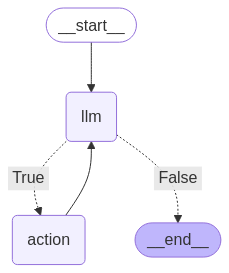

In [234]:
from IPython.display import Image, display
Image(agent.graph.get_graph().draw_mermaid_png())

In [235]:
langchain.debug=True
messages = [HumanMessage(content="What is 11 times 142 divided by 8?")]
# TODO make it use one tool at a time
result = agent.graph.invoke({"messages": messages})

[chain/start] [chain:LangGraph] Entering Chain run with input:
[inputs]
[chain/start] [chain:LangGraph > chain:__start__] Entering Chain run with input:
[inputs]
[chain/start] [chain:LangGraph > chain:__start__ > chain:ChannelWrite<...>] Entering Chain run with input:
[inputs]
[chain/end] [chain:LangGraph > chain:__start__ > chain:ChannelWrite<...>] s] Exiting Chain run with output:
[outputs]
[chain/start] [chain:LangGraph > chain:__start__ > chain:ChannelWrite<start:llm>] Entering Chain run with input:
[inputs]
[chain/end] [chain:LangGraph > chain:__start__ > chain:ChannelWrite<start:llm>] s] Exiting Chain run with output:
[outputs]
[chain/end] [chain:LangGraph > chain:__start__] s] Exiting Chain run with output:
[outputs]
[chain/start] [chain:LangGraph > chain:llm] Entering Chain run with input:
[inputs]
[llm/start] [chain:LangGraph > chain:llm > llm:ChatOllama] Entering LLM run with input:
{
  "prompts": [
    "System: You are a smart research assistant. Use the multiply_with_decora

In [227]:
result['messages']

[HumanMessage(content='What is 11 times 142 divided by 8?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.1:8b', 'created_at': '2025-03-08T09:14:14.810341Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2820774625, 'load_duration': 44469750, 'prompt_eval_count': 330, 'prompt_eval_duration': 1895000000, 'eval_count': 47, 'eval_duration': 877000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-33e8ea93-fb4a-44f4-915b-d8f56b9f56cd-0', tool_calls=[{'name': 'multiply_with_decorator', 'args': {'a': 11, 'b': 142}, 'id': '4375ed2b-dcbf-456c-b242-ced8695a9607', 'type': 'tool_call'}, {'name': 'divide', 'args': {'a': 1562, 'b': 8}, 'id': '81dd6019-0ad5-4fb1-8740-8e45c4894f9c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 330, 'output_tokens': 47, 'total_tokens': 377}),
 ToolMessage(content='1562', name='multiply_with_decorator', tool_call_id='4375ed2b-dcb